# Knowledge Base | Articles search

## Need for a knowledge base

At the origin of this project is my experience of two very different type of consulting firms. In 2021, I spent 4 months as a visiting associate at the [Boston Consulting Club](https://www.bcg.com/belgium). With little technical background, I was wuickly able to deliver complex pricing analysis, industry benchmarking and positioning studies. The reason for this is that BCG had an extensive and well structured knowledge base (slides, articles, and market research). I was able to find the right information in a matter of minutes.

A year later, I joined a small consulting called [Reacfin](https://www.reacfin.com/) specialized in actuarial sciences and risk management. There knowledge was not articulated in a structured way. Luckily my colleagues were highly knowledgeable and took the time to bring me up to speed. However, I could not help but think that the firm was missing out on a lot of potential by not having a knowledge base.

I pursued my research on the topic and found out that the knowledge base is a key factor of success for consulting firms. However, accumulating knowledge is not enough. The knowledge base must be structured and easily accessible.

*Supporting articles on the problematic:*

- [Dunford, R. (2000), "Key challenges in the search for the effective management of knowledge in management consulting firms", Journal of Knowledge Management, Vol. 4 No. 4, pp. 295-302.](https://doi.org/10.1108/13673270010379849)
- [Werr, A., & Stjernberg, T. (2003). Exploring Management Consulting Firms as Knowledge Systems. Organization Studies, 24(6), 881-908.](https://doi.org/10.1177/0170840603024006004)
- [Sarvary, M. (1999). Knowledge Management and Competition in the Consulting Industry. California Management Review, 41(2), 95-107.](https://doi.org/10.2307/41165988)


## Project overview

Until now I had not found a satisfactory way to navigate existing documentation. For example, a keywords search would require a standardisation of the vocabulary across the firm, which is time consuming, arbitrary, and not flexible. However, we discovered the concept of [semantic search](https://www.sbert.net/examples/applications/semantic-search/README.html) which is a search technique that takes into account the meaning and context of words. This is exactly what we need to navigate our knowledge base intuitively.

This first notebook will focus on the implementation of a semantic search engine for scientific articles. This is a proof of concept for a larger project including notebooks and functions to support the technical profiles at Reacfin. Here are the different steps of the notebook:
1. [Abstract search](#1.-Abstract-search): we will extract the abstracts of our knowledge base, then tokenize and vectorize them. We will then use the vectorized abstracts to find the most similar abstracts to a given query.
2. [Full text retrieval](#2.-Full-text-retrieval): we will use the result of the abstracts search as index to retrieve the full text of the most relevant articles.
3. [Knowledge space](#3.-Knowledge-space): we will use the abstracts embeddings to identify clusters of articles and visualize them in a 2D space. This will help us understand the structure of our knowledge base and navigate it intuitively.
4. [Full text search](#4.-Full-text-search): we will use the full text of the articles to find the most relevant chunks of text to a given query. This will allow us to find detailed information on a specific topic. This can also be used as the first step for a RAG chatbot.



---
---
*This is the first notebook of a series of 4. The other notebooks are:*
- *`Knowledge Base | Notebooks search`: Identify relevant notebooks based on Markdown cells*
- *`Knowledge Base | Functions search`: Identify relevant functions based on Docstrings*
- *`Knowledge Base | RAG chatbot`: Augment an open-source LLM with the knowledge retrieved*


# 1. Abstract search
*back to [Project Overview](#project-overview)*


First, we'll need to create our knowledge base. `Reacfin` shared a repository of 37 articles. For the preprocessing, we will:
- 1.1. Extract all articles from the ZIP file and keep the PDFs of a certain size only
- 1.2. Extract the abstracts from the articles using the `pdfminer` library
- 1.3. Set up a validation framework with example queries to test the semantic search
- 1.4. Try different combinations of embeddings and retrieval models to find the best performing model

In [149]:
# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [167]:
from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitz
import re
import tqdm
tqdm.tqdm.pandas()
from transformers import pipeline
summarizer = pipeline("summarization", model="Falconsai/text_summarization")
import datetime
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import spacy
import string

## 1.1. Extract articles from ZIP file

We will use the `zipfile` library to extract the articles from the ZIP file and the `os` and `shutil` libraries to move the PDFs to the original directory and delete the temporary directory. Then, we will use the `PyMuPDF` (imported as `fitz`) library to filter out the PDFs that are too large for our proof of concept (it prevents having too many chunks of the same pdf in our vectorspace in the upcoming [Full text search](#4.-Full-text-search)). We will keep the PDFs that are less than 30 pages long.

In [151]:
def extract_zip(from_dir, to_dir, folder_name='Academic', verbose=True):
    """Extract the files from the zip files (can be multiple) and move them to the chosen folder

    Parameters
    ----------
    from_dir : str
        Directory where the zip files are located
    to_dir : str
        Directory where the labels will be extracted
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    None
        The labels are extracted and moved to the chosen folder
    """
    all_files = [file for file in os.listdir(from_dir) if ".zip" in file]
    i = 0
    for file in all_files:
        if verbose:
            print(f"Extracting: {file}")
        with ZipFile(from_dir+"/"+file, "r") as zipObj:
            # Keep only the pdf files to extract
            all_objects = zipObj.namelist()
            all_objects = [x for x in all_objects if x.endswith(".pdf")]
            # Extract all the chosen files
            for object in all_objects:
                zipObj.extract(object, to_dir)
        i += 1
    if verbose:
        print(f"{i} files extracted")

    # Delete zip files
    for file in all_files:
        os.remove(from_dir+"/"+file)

    # Move all labels to the root folder
    for file in os.listdir(to_dir+f"/{folder_name}"):
        shutil.move(os.path.join(to_dir+f"/{folder_name}", file), to_dir)

    # Delete empty folder
    os.rmdir(to_dir+f"/{folder_name}")
    if verbose:
        print("Repository cleaned")

In [152]:
files = os.listdir('kb_articles')
if any(file.endswith(".zip") for file in files):
    extract_zip(
        from_dir = 'kb_articles',
        to_dir='kb_articles', # same directory
        folder_name='Academic', # folder name where the labels are extracted
        verbose=True)

We will now make a first structure of our knowledge base with the title, page count, abstracts (empty for now), and the path to the PDFs. We see that the `doc.metadata` method of the `fitz` library allows us to extract a lot of information but for a few articles only so we will fetch the information manually instead.

In [153]:
pd.set_option('display.max_columns', None)
kb_articles = pd.DataFrame(columns=['title', 'pages', 'abstract', 'path'])


def structure_kb(kb_dir, index, verbose=True):
    """Structure the knowledge base into a dataframe with the following columns: title, pages, abstract, path

    Parameters
    ----------
    kb_dir : str
        Directory where the knowledge base is located
    index : pd.core.frame.DataFrame or str
        Path to the dataframe or the dataframe itself
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    pd.core.frame.DataFrame
        Dataframe with the knowledge base
    """
    if type(index) != pd.core.frame.DataFrame:
        try:
            index = pd.read_excel(index)
        except:
            index = pd.read_csv(index)
    # Crawl the knowledge base and extract the metadata
    for file in os.listdir(kb_dir):
        if file.endswith(".pdf"):
            path = os.path.join(kb_dir, file)
            doc = fitz.open(path)
            # Append the metadata to the dataframe
            if path not in index.path.values:
                index.loc[len(index)] = [file.removesuffix('.pdf'), len(doc), None, path]
                if verbose:
                    print(f"Title: {file.removesuffix('.pdf')}")
                    print(f"Pages: {len(doc)}")
                    print(f"Path: {path}")
    return index

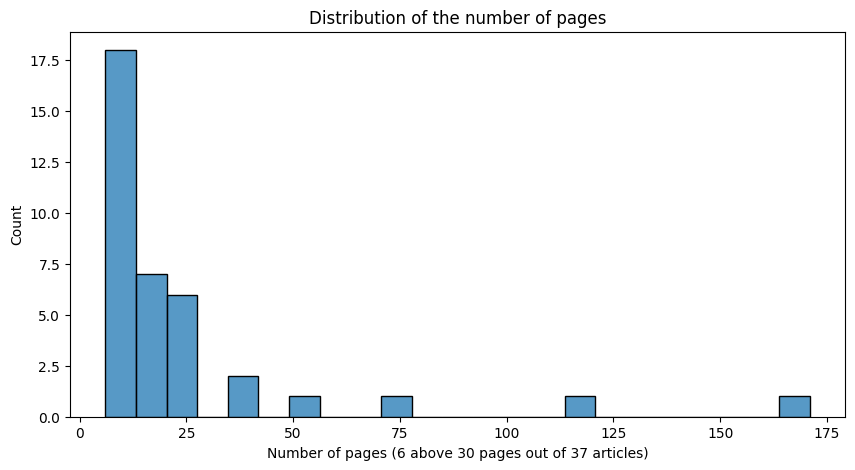

Proportion of articles with more than 30 pages: 16.22%
31 articles indexed in the knowledge base
CPU times: total: 734 ms
Wall time: 2.02 s


In [154]:
%%time

kb_articles = structure_kb("kb_articles", kb_articles, verbose=False)
plt.figure(figsize=(10, 5))
sns.histplot(kb_articles.pages)
plt.title("Distribution of the number of pages")
plt.xlabel(f"Number of pages ({len(kb_articles[kb_articles.pages > 30])} above 30 pages out of {len(kb_articles)} articles)")
plt.show()
# It seems that the majority of the articles have less than 30 pages which should be a good cut-off point
print(f"Proportion of articles with more than 30 pages: {len(kb_articles[kb_articles.pages > 30])/len(kb_articles):.2%}")

# Remove articles with more than 30 pages
kb_articles_poc = kb_articles[kb_articles.pages <= 30]
kb_articles_poc.reset_index(inplace=True, drop=True)
# kb_articles_poc.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file
print(f"{len(kb_articles_poc)} articles indexed in the knowledge base")

## 1.2. Extract the abstracts

We will look at the first page, extract the text, set all characters to lowercase and then look for the word `abstract` to find the beginning of the abstract. Then, we will look for `introduction` to mark the end of the abstract. If `introduction` cannot be found, we will take the first 512 characters.

In [155]:
for path in kb_articles_poc.path:
    with fitz.open(path) as doc:
        text = ""
        text += doc[0].get_textpage().extractText()
        try:
            print("introduction" in text.lower().split("abstract")[1])
        except:
            print(path)

# In some pdf files (elsevier), the abstract cannot be found >>> Regular expression to find the abstract even with spaces
# ex: pdf with index 7 has "a b s t r a c t" instead of abstract
# In some pdf files, the introduction cannot be found >>> Take the 3 first pages instead of the first one
# ex: pdf with index 5 has the introduction on the second page

True
True
True
True
True
False
True
kb_articles\Climate risks and financial stability Evidence from the European financial system - JFS 2023.pdf
True
True
True
True
True
False
True
True
True
True
True
kb_articles\Lee et al - 2021 - Graph CNN credit default prediction.pdf
True
True
True
kb_articles\Ma et al - 2018 - Study on a prediction of P2P network loan LGBM XGB.pdf
True
True
True
kb_articles\Starosa - LGD decomposition using mixture distributions nof in-default events - EJOR 2023.pdf
True
True
True


In [156]:
def extract_abstract(path, char_max=1000):
    """Extract the abstract from a pdf file

    Parameters
    ----------
    path : str
        Path to the pdf file
    char_max : int, optional
        Maximum number of characters to extract if introduction not found, by default 1000
    
    Returns
    -------
    str
        Abstract of the pdf file
    """
    with fitz.open(path) as doc:
        text = ""
        # Add two extra pages to the text
        for i in range(3):
            text += doc[i].get_textpage().extractText().lower()
        # Find the abstract with white spaces inbetween characters
        ret = None
        s=0
        while not ret and s<3:
            search = "a.{"+str(s)+"}b.{"+str(s)+"}s.{"+str(s)+"}t.{"+str(s)+"}r.{"+str(s)+"}a.{"+str(s)+"}c.{"+str(s)+"}t"
            ret = re.search(search, text)
            s+= not ret
        abstract_unbounded = re.split(search, text)[1]
        # Find the introduction with white spaces inbetween characters
        ret = None
        s=0
        while not ret and s<3:
            search = "i.{"+str(s)+"}n.{"+str(s)+"}t.{"+str(s)+"}r.{"+str(s)+"}o.{"+str(s)+"}d.{"+str(s)+"}u.{"+str(s)+\
            "}c.{"+str(s)+"}t.{"+str(s)+"}i.{"+str(s)+"}o.{"+str(s)+"}n"
            ret = re.search(search, text)
            i+= not ret
        if not ret:
            abstract = abstract_unbounded[:char_max]
        abstract = re.split(search, abstract_unbounded)[0]
        return abstract

In [157]:
%%time

# for path in kb_articles_poc.path:
#     try:
#         print(f"Length:{len(extract_abstract(path))}")
#     except:
#         print(path)
## The trouble shooting has worked!

kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
kb_articles['abstract'] = kb_articles.path.progress_apply(extract_abstract)
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 34.20it/s]

CPU times: total: 828 ms
Wall time: 955 ms


## 1.3. Validation framework

In order to validate our semantic search engine, we will use text summarization to create a summary of the abstracts. We use the `text_summarization` developed by [Falconsai](https://huggingface.co/Falconsai/text_summarization) and set a maximum length of 50 words. These summaries will be used as queries for our semantic search engine. We can then validate the engine by checking if the original article is in fact matching the query.

In [158]:
def create_validation_query(abstract, max_length=50):
    """Create a validation query from the abstract

    Parameters
    ----------
    abstract : str
        Abstract of the article
    max_length : int, optional
        Maximum number of words in the query, by default 50
    
    Returns
    -------
    str
        Validation query
    """
    summary = summarizer(abstract, max_length=max_length)
    return summary[0]['summary_text']

In [159]:
%%time

# We create a validation query from each abstract
kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
if 'validation_query' not in kb_articles.columns:
    kb_articles['validation_query'] = kb_articles.abstract.progress_apply(create_validation_query)
else:
    print("Validation query already created")

# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

Validation query already created
CPU times: total: 15.6 ms
Wall time: 18.9 ms


While reading the summary queries, we notice that some articles are duplicates with different titles.
- `Credit scroring models v2.0 submitted IRFA` and `Dessain - 2024 - Credit scoring performance metrics` are the same article
- `Dushimimana et al - 2020 - Use of machine learning techniques to create a credit score model for airtime loans` and `Dushimimana et al. - 2020 - Use of machine learning techniques to create a credit score model for airtime loans` are the same article

Thanks to this first application of NLP (through text summarization), we are already able to explore the structure of our knowledge base and identify duplicates which we can remove.

In [160]:
kb_articles = kb_articles[np.logical_not(kb_articles.validation_query.duplicated()).tolist()].reset_index(drop=True)
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

Now we can create a performance metric for our semantic search engine. The score will be very simple: 1 if the original article is returned, 0 otherwise. We will then compute the average score for all articles. The `retrieval_score` will then be the proportion of articles that are correctly returned by the semantic search engine (based on the validation query). We will keep track of the `retrieval_score` for each iteration in our training (kept in the `retrieval_logs` excel file).

In [178]:
# retrieval_logs = pd.DataFrame(columns=['embedding', 'retriever', 'retrieval_score', 'time_stamp'])
# retrieval_logs.to_excel("retrieval_logs.xlsx", index=False)

def retrieval_score(retriever, index = "kb_articles/AAA_index.xlsx", name_col="title", query_col="validation_query", verbose=True):
    """Get the retrieval score of a retriever

    Parameters
    ----------
    retriever : function
        Returns the title of the retrieved article given a query
    index : str, optional
        Path to the knowledge base index, by default "kb_articles/AAA_index.xlsx"
    name_col : str, optional
        Name of the column containing the titles, by default "title"
    query_col : str, optional
        Name of the column containing the validation queries, by default "validation_query"
    verbose : bool, optional
        Print the execution details, by default True

    Returns
    -------
    float
        Proportion of retrieved articles
    """
    index = pd.read_excel(index)
    def retrieve(query):
        return retriever(query)
    retrieved = 0
    observations = 0
    for _,row in index.iterrows():
        observations += 1
        if verbose:
            print(f"-| {observations} |-"+"-"*(10-len(str(observations))))
        query = row[query_col]
        if verbose:
            print(f"   Query: {query}")
        results = retrieve(query)
        if verbose:
            print(f"   Results: {results}")
        if row[name_col] == results:
            retrieved += 1
            if verbose:
                print("   > Retrieved!")
        else:
            if verbose:
                print("   > Not retrieved!")
    return retrieved/observations

def log_retriever(
        embedding_name, retriever_name, retriever, scorer=retrieval_score,
        logs="retrieval_logs.xlsx", verbose=True):
    """Log the retrieval score of a retriever

    Parameters
    ----------
    embedding_name : str
        Name of the embedding
    retriever_name : str
        Name of the retriever
    retriever : function
        Returns the title of the retrieved article given a query
    scorer : function
        Returns the retrieval score of a retriever
    logs : str, optional
        Path to the logs, by default "retrieval_logs.xlsx"
    verbose : bool, optional
        Print the execution details, by default True
    
    Returns
    -------
    logs_df : dataframe
        Logs of the retrievers
    """
    score = scorer(retriever, verbose=False)
    if verbose:
        print(f"Retrieval score of {score:.2%}")
    logs_df = pd.read_excel(logs)
    if verbose:
        print("   Logging experiment...")
    if embedding_name is None:
        embedding_name = input("What embedding did you use? ")
    if retriever_name is None:
        retriever_name = input("What retriever did you use? ")
    time_stamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    existing_combinations = [logs_df.embedding[i]+logs_df.retriever[i] for i in range(len(logs_df))]
    if embedding_name+retriever_name not in existing_combinations:
        logs_df.loc[len(logs_df)] = [embedding_name, retriever_name, score, time_stamp]
        logs_df.sort_values(by="retrieval_score", ascending=False, inplace=True)
        logs_df.to_excel(logs, index=False)
        if verbose:
            print("   Experiment logged.")
    else:
        if verbose:
            print("   Experiment already logged.")
    return logs_df

In [162]:
# Test the validation framework with mock retrievers

def ideal_retriever(query, index = "kb_articles/AAA_index.xlsx"):
    index = pd.read_excel(index)
    return index[index.validation_query == query].title.values[0]

def random_retriever(query, index = "kb_articles/AAA_index.xlsx"):
    index = pd.read_excel(index)
    return np.random.choice(index.title.values)

# Log the retrieval score of the mock retrievers
_ = log_retriever(
    embedding_name="Fake embedding", retriever_name="Ideal retriever", retriever=ideal_retriever,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
np.random.seed(42)
log_retriever(
    embedding_name="Fake embedding", retriever_name="Random retriever", retriever=random_retriever,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

Retrieval score of 100.00%
   Logging experiment...
   Experiment already logged.
Retrieval score of 6.90%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
2,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
3,BOW without prep,dot_score,0.034483,2024-01-30 14:10


## 1.4. Try different combinations of embeddings and retrieval models

Now that we have a knowledge base, the abstracts of the different articles, and a validation framework, we can start trying out different combinations of embeddings and retrieval models to find the most effective semantic search engine. We will try out three embeddings and three retrieval models. The embeddings are:
- `Own embedding`: we will use a self-defined Bag of Words embedding as a baseline embedding.
- `Pretrained embeddings`: we will then use pretrained embeddings from the [sentence-transformers](https://www.sbert.net/) library.

For each of these embeddings, we will use two different ways of retrieving the most similar document:
- `dot_score`: dot product between the embeddings
- `cos_sim`: cosine similarity between the embeddings

In [163]:
# Set up our 'home-made' vectorstore
embeddings = pd.read_excel("kb_articles/AAA_index.xlsx").copy()
embeddings.columns
embeddings.drop(columns=['pages','path'], inplace=True)
# embeddings[['title','validation_query', 'abstract']].to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

### A. BOW on a character level

We start by using the BOW embedding without tokenizing and lemmatizing upfront. We'll test the three retrieval models on this embedding.

In [164]:
embeddings = pd.read_pickle("embeddings.pkl")

# BOW embedding: source https://github.com/MathieuDemarets/vlerick-mai-nlp-2023/blob/Local/ASS1%20Modelling.ipynb
# > Reused vocabBOW

def vocabBOW(df, vocab_col='abstract', vocab_size=1000, verbose=False):
    """Creates a vocabulary of the most common words in the corpus and maps each word to an integer

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    vocab_col : str, optional
        Name of the column containing the documents, by default 'abstract'
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    verbose : bool, optional
        Display details, by default False

    Returns
    -------
    tokenMap : dict
        Word to integer mapping
    tokenMapInverse : dict
        Integer to word mapping
    tokenFreq : Counter
        Word frequencies
    """
    tokenFreq = Counter()
    df[vocab_col].progress_apply(lambda x: tokenFreq.update(x))

    if verbose:
        print(f"Total number of words: {sum(tokenFreq.values())}")
        print(f"Number of unique words: {len(tokenFreq)}")
        print(f"Most common words: {tokenFreq.most_common(5)}")
        print(f"Least common words: {tokenFreq.most_common()[:-5:-1]}")
    
    tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(vocab_size-1))} # -1 to account for the <oov> token
    tokenMap["<oov>"]=0 # Out of vocabulary token to account for words not in the vocabulary
    tokenMapInverse = {v: k for k,v in tokenMap.items()}

    return tokenMap, tokenMapInverse, tokenFreq

tokenMap, tokenMapInverse, tokenFreq = vocabBOW(embeddings, vocab_size=1000, verbose=True) 

# > Reused embedBOW

def embedBOW(example, vocab_size=1000, tokenMap=tokenMap):
    """Embeds a document as a Bag of Words vector

    Parameters
    ----------
    example : list
        List of tokens
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    tokenMap : dict, optional
        Word to integer mapping, by default tokenMap
    
    Returns
    -------
    embedding : np.array
        Bag of Words vector
    """
    embedding = np.zeros(vocab_size)
    for token in example:
        try:
            tokenIndex = tokenMap[token] # get index of token in vocabulary
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1 # increment count of token
    return embedding

# embeddings["embeddedBOW"] = embeddings['abstract'].progress_apply(embedBOW) 
# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

In [165]:
def BOW_char_cos(query):
    embedded_query = embedBOW(query)
    embedded_corpus = embeddings["embeddedBOW"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

def BOW_char_dot(query):
    embedded_query = embedBOW(query)
    embedded_corpus = embeddings["embeddedBOW"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

# Log the retrieval score of the BOW_char_cos retriever
log_retriever(
    embedding_name="BOW without prep", retriever_name="cos_sim", retriever=BOW_char_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
log_retriever(
    embedding_name="BOW without prep", retriever_name="dot_score", retriever=BOW_char_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

Retrieval score of 48.28%
   Logging experiment...
   Experiment already logged.
Retrieval score of 3.45%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
2,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
3,BOW without prep,dot_score,0.034483,2024-01-30 14:10


### B. BOW based on the spacy tokenizer

In the previous embedding, we focussed on the frequency of characters only. Surprisingly, this naive embedding already identified 48% of the articles correctly. We will now use the spacy tokenizer to tokenize the abstracts, create a new vocabulary and a new embedding. 

We expect a better performance with this embedding as the tokenizer will clean the abstract from punctuation and stop words. We will also test one embedding with lemmatization and one without (as maybe the nuance might help differentiate better between articles). We will then test the two retrieval models with the query tokenization.

In [179]:
# Spacy tokenizer: source https://github.com/MathieuDemarets/vlerick-mai-nlp-2023/blob/Local/ASS1%20Exploration.ipynb

# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
# We made sure that no text was over 500k characters so no try except needed to catch the exception
def spacy_tokenizer(sentence, lemmatize=True):
    """Transforms a sentence into a list of (lemma) tokens and remove stop words and punctuation.

    Parameters
    ----------
    sentence : str
        Input sentence.
    lemmatize : bool, optional
        Whether to lemmatize the tokens, by default True.

    Returns
    -------
    list
        List of lemma tokens.
    """
    mytokens = nlp(sentence.lower())
    mytokens = [word for word in mytokens if not word.is_oov and not word.is_stop and not word.is_punct]
    if lemmatize:
        mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    else:
        mytokens = [word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

In [173]:
embeddings = pd.read_pickle("embeddings.pkl")
spacy_tokenizer_no_lemma = lambda x: spacy_tokenizer(x, lemmatize=False)
embeddings["tokens_no_lemma"] = embeddings["abstract"].progress_apply(spacy_tokenizer_no_lemma)
embeddings["tokens_lemma"] = embeddings["abstract"].progress_apply(spacy_tokenizer)
# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

 10%|█         | 3/29 [00:00<00:00, 27.85it/s]

100%|██████████| 29/29 [00:01<00:00, 23.94it/s]


In [180]:
# Create the new embedding functions and abstract embeddings for the tokenized abstracts

# No lemma
tokenMap_no_lemma, tokenMapInverse_no_lemma, tokenFreq_no_lemma = vocabBOW(embeddings, vocab_col='tokens_no_lemma', vocab_size=1000, verbose=True)
embedBOW_no_lemma = lambda x: embedBOW(x, vocab_size=1000, tokenMap=tokenMap_no_lemma)
embeddings["embeddedBOW_no_lemma"] = embeddings['tokens_no_lemma'].progress_apply(embedBOW_no_lemma)

# Lemma
tokenMap_lemma, tokenMapInverse_lemma, tokenFreq_lemma = vocabBOW(embeddings, vocab_col='tokens_lemma', vocab_size=1000, verbose=True)
embedBOW_lemma = lambda x: embedBOW(x, vocab_size=1000, tokenMap=tokenMap_lemma)
embeddings["embeddedBOW_lemma"] = embeddings['tokens_lemma'].progress_apply(embedBOW_lemma)

# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

100%|██████████| 29/29 [00:00<00:00, 14533.97it/s]


Total number of words: 3253
Number of unique words: 1368
Most common words: [('models', 59), ('financial', 52), ('model', 39), ('learning', 36), ('data', 33)]
Least common words: [('parameters', 1), ('release', 1), ('professionals', 1), ('ciency', 1)]


100%|██████████| 29/29 [00:00<00:00, 14554.84it/s]


Total number of words: 3232
Number of unique words: 1144
Most common words: [('model', 98), ('financial', 53), ('default', 32), ('datum', 31), ('learning', 30)]
Least common words: [('parameter', 1), ('professional', 1), ('ciency', 1), ('potentially', 1)]


100%|██████████| 29/29 [00:00<00:00, 14537.45it/s]


In [181]:
# Create the new retrievers based on the two new abstract embeddings and the embedding functions

# 1. Spacy without lemmatization and cosine similarity

def spacy_no_lemma_cos(query):
    embedded_query = embedBOW_no_lemma(spacy_tokenizer_no_lemma(query))
    embedded_corpus = embeddings["embeddedBOW_no_lemma"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

# 2. Spacy without lemmatization and dot product

def spacy_no_lemma_dot(query):
    embedded_query = embedBOW_no_lemma(spacy_tokenizer_no_lemma(query))
    embedded_corpus = embeddings["embeddedBOW_no_lemma"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

# 3. Spacy with lemmatization and cosine similarity

def spacy_lemma_cos(query):
    embedded_query = embedBOW_lemma(spacy_tokenizer(query))
    embedded_corpus = embeddings["embeddedBOW_lemma"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

# 4. Spacy with lemmatization and dot product

def spacy_lemma_dot(query):
    embedded_query = embedBOW_lemma(spacy_tokenizer(query))
    embedded_corpus = embeddings["embeddedBOW_lemma"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title

In [183]:
# Log the retrieval score of the new retrievers

_ = log_retriever(
    embedding_name="Spacy without lemmatization", retriever_name="cos_sim", retriever=spacy_no_lemma_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
_ = log_retriever(
    embedding_name="Spacy without lemmatization", retriever_name="dot_score", retriever=spacy_no_lemma_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
_ = log_retriever(
    embedding_name="Spacy with lemmatization", retriever_name="cos_sim", retriever=spacy_lemma_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
log_retriever(
    embedding_name="Spacy with lemmatization", retriever_name="dot_score", retriever=spacy_lemma_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

Retrieval score of 96.55%
   Logging experiment...
   Experiment already logged.
Retrieval score of 62.07%
   Logging experiment...
   Experiment already logged.
Retrieval score of 96.55%
   Logging experiment...
   Experiment already logged.
Retrieval score of 82.76%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,Spacy without lemmatization,cos_sim,0.965517,2024-01-30 16:36
2,Spacy with lemmatization,cos_sim,0.965517,2024-01-30 16:36
3,Spacy with lemmatization,dot_score,0.827586,2024-01-30 16:40
4,Spacy without lemmatization,dot_score,0.620690,2024-01-30 16:40
5,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
6,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
7,BOW without prep,dot_score,0.034483,2024-01-30 14:10


In [185]:
print(f"Our best model achieves a {retrieval_score(spacy_no_lemma_cos, verbose=True):.2%} retrieval score")

-| 1 |----------
   Query: neural additive models (nams) combine expressivity of dnns with inherent intelligibility of generalized additive models . nams learn a linear combination of neural networks that each attend to a single input feature
   Results: Agarwal et al - 2021 - neural additive models interpretable machine learning with neural nets - NeurIPS-2021-
   > Retrieved!
-| 2 |----------
   Query: the model predictive accuracy assessment represents a basic requirement . on the one hand, literature provides several predictive accuracy measures but, on the other hand, these measures are typically computationally intensive or are based on subjective criteria .
   Results: Agosto et al - 2020  - A new proposal to improve credit scoring model predictive accuracy
   > Retrieved!
-| 3 |----------
   Query: our approach is considering the cost matrix and cumulative profit chart for setting the threshold value . in the paper we examine the performance of several models trained with homog

When we use the spacy tokenization (with or without lemmatization), we see that the `cos_sim` retrieval model performs very well. In fact, it makes a single mistake out of the 29 articles in the knowledge base. We will visualize the embeddings in the [Knowledge space](#3.-Knowledge-space) section to understand why this is the case.

In [224]:
# > Upcoming code inspired from https://colab.research.google.com/drive/1U05kuyx_EDtuSpa8LggNtpYax7FFC7O0?usp=sharing#scrollTo=uhDYYML17-Ds
# > Original function and content for the system role

from llamaapi import LlamaAPI
import json

llama = LlamaAPI("LL-DtYGko3WDDw6ylKszULyulXS4HFAIpu7xUG5ypGNPXtJWaur6aQNmWCTJ96sQvMf")

def rephrase_query(query, context):
    """Rephrase the query using the Llama API and the context

    Parameters
    ----------
    query : str
        Query to rephrase

    Returns
    -------
    str
        Rephrased query
    """
    api_request_json = {
        "model": "llama-13b-chat", # the 70B model is too slow for inference
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": query},
        ]
    }
    response = llama.run(api_request_json)
    output = json.loads(response.text)
    return output["choices"][0]['message']['content']

In [221]:
kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
# output = rephrase_query(kb_articles.iloc[0].validation_query)
# print(f"Original query: {kb_articles.iloc[0].validation_query}")
# print(f"Rephrased query: {output}")
# Validated!

In [228]:
# Rephrase the validation queries to make them closer to realistic text snippets or explanations
rephraser = lambda x: rephrase_query(
    x, context="You are a teacher and will rephrase the given phrase to make them easier to understand. Don't say ANYTHING else than the paraphrase. Keep it short")
if 'rephrased_validation_query' not in kb_articles.columns:
    kb_articles['rephrased_validation_query'] = kb_articles.validation_query.progress_apply(rephraser)
# Create a plausible question to ask about the article summary
questioner = lambda x: rephrase_query(
    x, context="You are a student and will ask a question specific to the given phrase. Don't say ANYTHING else than the question. Keep it short")
if 'validation_question' not in kb_articles.columns:
    kb_articles['validation_question'] = kb_articles.validation_query.progress_apply(questioner)

In [226]:
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

# 2. Full text retrieval
*back to [Project Overview](#project-overview)*

# 3. Knowledge space
*back to [Project Overview](#project-overview)*

# 4. Full text search
*back to [Project Overview](#project-overview)*

Thank you for reading this notebook. I hope you enjoyed it and that it gave you some insights into the potential of semantic search for knowledge management.

---
Mathieu Demarets (mathieu.demarets@edu.vlerick.com)